# FAA: Práctica 2

### Autores: David Cabornero Pascual y Mario García Pascual

## 0. Introducción

La práctica 2 consiste en implementar en Python dos nuevos clasificadores que se sumarán al actual clasificador de Naive-Bayes: regresión logística y vecinos próximos. Posteriormente, comprobamos cómo se comportan las funciones de scipy respecto a nuestras implementaciones. Finalmente, se hace un análisis ROC de todos los clasificadores implementados hasta el momento.

A continuación añadimos todas las librerías que se usarán en el notebook y declaramos los datos que se van a usar.

In [79]:
%load_ext autoreload
%autoreload 2

import numpy as np

from Clasificador import Clasificador,ClasificadorRegresionLogistica,ClasificadorNaiveBayes,ClasificadorVecinosProximos
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple, ValidacionCruzada

from astropy.table import QTable, Table, Column

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

dataWDBC = Datos('wdbc.data', predNominal=True)
dataIndians = Datos('pima-indians-diabetes.data', predNominal=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Vecinos próximos

Se ha implementado el clasificador de vecinos próximos al que se le deben indicar tres parámetros: el número de vecinos, la distancia utilizada y si se quiere normalizar. Los dos últimos parámetros son opcionales, y si no se menciona la distancia será la euclidea y se normalizarán los datos.

Dado que este algoritmo tiene bastante más coste de predicción que regresión logística, no se ejecutará un gran número de veces. Por ello, para conseguir que ese número de veces arroje un error consistente se va a realizar validación cruzada en toda la sección.

A continuación analizaremos las dos bases de datos que se nos han encargado. Se seguirá el siguiente procedimiento:
* Análisis de la normalización: variando el número de vecinos (1,5,11,21) y la distancia utilizada se muestra si la normalización da o no unos resultados significativamente mejores.
* Análisis de los parámetros: se muestran en una gráfica los errores obtenidos para un cierto número de vecinos y una cierta distancia y se evalúan dichos resultados. En este apartado ya solo se trabaja con los datos normalizados, ya que en el peor de los casos la normalización no ayudará demasiado a obtener mejores resultados, pero en ningún caso debería empeorarlos.

In [61]:
# Devuelve tres arrays: datos normalizados, sin normalizar y la diferencia entre ambos. Prec es la precisión de
# decimales que se quiere en los resultados
def data_knn(distancias,vecinos,data,numEx=5,prec=5):
    particionado = ValidacionCruzada(numEx)

    datosTablaN = [vecinos,]
    datosTabla = [vecinos,]

    for dist in distancias:
        lstN = []
        lst = []
        for k in vecinos:
            # Normalizado
            clN = ClasificadorVecinosProximos(k,distancia=dist)
            erroresN = clN.validacion(particionado,data)
            # Sin normalizar
            cl = ClasificadorVecinosProximos(k,distancia=dist,normaliza=False)
            errores = cl.validacion(particionado,data)
            # Añadimos a las columnas
            lstN.append(np.around(np.mean(erroresN),prec))
            lst.append(np.around(np.mean(errores),prec))
        datosTabla.append(lst)
        datosTablaN.append(lstN)
    diff = [vecinos,]+list(np.around((np.array(datosTabla)-np.array(datosTablaN)),prec)[1:])
    return datosTablaN,datosTabla,diff

# Impresión de las tablas
def print_knn(datosTablaN,datosTabla,diff,distancias):
    header = ['Num. Vecinos'] + distancias
    
    print('Sin normalizar:')
    t = Table(datosTabla,names=header)
    print(t)
    print('\n')

    print('Normalizando:')
    tN = Table(datosTablaN,names=header)
    print(tN)
    print('\n')

    print('Diferencias:') 
    tDif = Table(diff,names=header)
    print(tDif)

# Graficación de resultados
def plot_knn(datosTablaN,distancias,title):
    vecinos = np.array(datosTablaN)[0]
    datos = np.array(datosTablaN)[1:]

    for i,dist in enumerate(distancias):
        plt.plot(vecinos,datos[i],label=dist)
    
    plt.xticks(vecinos)
    plt.legend()
    plt.xlabel('Número de vecinos')
    plt.ylabel('Tasa de error')
    plt.title(title)

    plt.show()

# Parámetros que se van a variar
distancias = ['euclidea','manhattan','mahalanobis']
vecinos = [1,5,11,21]

### 1.1. WDBC

A continuación se muestran tres tablas. En ellas, se muestra el error medio obtenido en la validación cruzada en el caso de que se normalice y de que no se normalice. Además se añade una tabla que muestra la diferencia entre el error cuando no se normaliza y cuando se normaliza. En esta tabla, un dato positivo indica que ha dado menos error la normalización.

Se avisa al lector de que la ejecución de estas funciones puede tardar unos cuantos minutos; rogamos paciencia.

In [59]:
datosTablaN,datosTabla,diff = data_knn(distancias,vecinos,dataWDBC,numEx=5)
print_knn(datosTablaN,datosTabla,diff,distancias)

Sin normalizar:
Num. Vecinos euclidea manhattan mahalanobis
------------ -------- --------- -----------
           1  0.08075   0.07025     0.16528
           5  0.06677   0.05249        0.19
          11    0.065   0.06335     0.21405
          21  0.07214   0.07031     0.29138


Normalizando:
Num. Vecinos euclidea manhattan mahalanobis
------------ -------- --------- -----------
           1   0.0473   0.04724     0.15436
           5  0.03674   0.03168     0.19348
          11  0.02997   0.04218     0.21954
          21  0.04407   0.05109     0.28296


Diferencias:
Num. Vecinos euclidea manhattan mahalanobis
------------ -------- --------- -----------
           1  0.03345   0.02301     0.01092
           5  0.03003   0.02081    -0.00348
          11  0.03503   0.02117    -0.00549
          21  0.02807   0.01922     0.00842


Como se puede observar, la diferencia de error entre la normalización y la no-normalización es prácticamente nula es sustancial en la distancia euclidea (sobre el 3%) y en la de Manhattan (sobre el 2%). Sin embargo, en Mahalanobis no llega al 1%, por lo que se puede deducir que prácticamente no influye.

Tras ver esto, nos quedamos con los datos normalizados por simplicidad y analizaremos los resultados obtenidos arriba mediante una graficación de los errores.

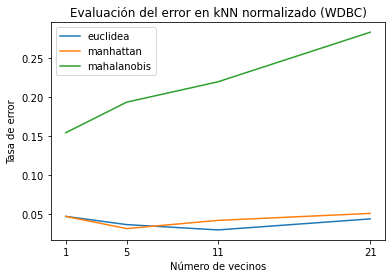

In [63]:
plot_knn(datosTablaN,distancias,'Evaluación del error en kNN normalizado (WDBC)')

Hay una conclusión que salta a la vista: la distancia de Mahalanobis es la peor de todas en este dataset. Además, parece que según se escogen más vecinos para el algoritmo el error empeora. En cambio, la distancia de Manhattan y la euclidea se comportan de manera similar, siendo algo mejor la de Manhattan.

Respecto a los vecinos, parece que cada uno tiene un mínimo en un número distinto. Si nos centramos en Manhattan (la distancia que da mejores resultados) parece que alcanza un mínimo de error en 5 vecinos, aumentando ligeramente si se toman más o menos vecinos. En cambio, la euclidea encuentra su mínimo en 11 vecinos y Mahalanobis en 1 vecino. Sin embargo, sobretodo la distancia euclidea y la de Manhattan parecen líneas muy ajustadas, y es posible que en algunas simulaciones encuentren su mínimo en otro punto.

### 1.2. Indians

A continuación procedemos a hacer los mismos cálculos con la segunda base de datos. De nuevo avisamos de que la ejecución de vecinos tarda especialmente, así que rogamos paciencia o fe en los resultados mostrados.

In [64]:
datosTablaN,datosTabla,diff = data_knn(distancias,vecinos,dataIndians)
print_knn(datosTablaN,datosTabla,diff,distancias)

Sin normalizar:
Num. Vecinos euclidea manhattan mahalanobis
------------ -------- --------- -----------
           1  0.30603   0.30985     0.29683
           5  0.28112   0.27866     0.27464
          11  0.26448   0.25254     0.27333
          21  0.25654   0.24379      0.2552


Normalizando:
Num. Vecinos euclidea manhattan mahalanobis
------------ -------- --------- -----------
           1  0.28648   0.32197     0.31403
           5   0.2642   0.28122     0.26194
          11  0.26704   0.27084     0.25918
          21    0.263      0.25     0.27489


Diferencias:
Num. Vecinos euclidea manhattan mahalanobis
------------ -------- --------- -----------
           1  0.01955  -0.01212     -0.0172
           5  0.01692  -0.00256      0.0127
          11 -0.00256   -0.0183     0.01415
          21 -0.00646  -0.00621    -0.01969


Ahora se puede observar que las escalas no están lo suficientemente dispersas como para que se pueda decir que la normalización está ayudando a la hora de calcular correctamente las predicciones. Aunque hay ciertas variaciones superiores al 1%, tras varias ejecuciones se puede ver que no siguen ningún patrón concreto.

Tras esto, de nuevo nos quedaremos por simplicidad con los datos normalizados. Procedemos a su graficación para hallar los resultados óptimos.

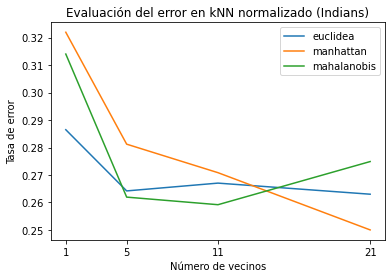

In [66]:
plot_knn(datosTablaN,distancias,'Evaluación del error en kNN normalizado (Indians)')

A diferencia de antes, ahora no parece que haya un claro perdedor. Sin embargo, esta database presenta una tasa de error mucho mayor que la anterior (incluso Mahalanobis presentaba menos errores antes). Podemos sacar tres conclusiones:
* La primera y más clara es que lo mejor para alcanzar el mínimo error es escoger 21 vecinos con la distancia de Manhattan. También parece ser que es a la única a la que le sienta bien tener cantidades tan grandes de vecinos.
* La distancia euclidea y Mahalanobis tienen errores similares, pero alcanzan el mínimo en un intervalo que se encuentra entre 5 y 11 vecinos.
* Dependiendo del número de vecinos que queramos utilizar deberíamos escoger una distancia distinta: para pocos vecinos la euclidea, para muchos vecinos Manhattan y para un número intermedio Mahalanobis.

## 2. Regresión logística

Ahora trataremos el segundo algoritmo de esta práctica: regresión logística mediante el método de la maximización de la verosimilitud. En este caso se pueden indicar tres parámetros opcionales: eta o constante de aprendizaje, número de épocas y normalización de la base de datos.

Aunque no se especifica en el enunciado, hemos decidido normalizar la base de datos utilizada, ya que también se ha hecho en clase de teoría. Se supone que con un número suficiente de épocas la normalización no debería afectar a la clasificación, pero sí que es cierto que una correcta normalización facilita la convergencia del algoritmo.

A diferencia del caso anterior, el algoritmo de regresión logísitica tarda muchísimo menos en ejecutarse. Por ello, se realizarán más ejecuciones y de esta forma obtendremos unos datos más fiables. Por ello, en esta parte se ha optado por trabajar con la validación simple, ya que una validación cruzada garantizaría una máxima independencia de los testSet, pero a su vez serían demasiado pequeños.

El procedimiento a seguir con cada base de datos será el mismo que en el apartado anterior:
* Análisis de la normalización: variando la constante de aprendizaje y el número de épocas se muestra si la normalización da o no unos resultados significativamente mejores. 
* Análisis de los parámetros: se muestran en una gráfica los errores obtenidos para una cierta constante de aprendizaje y un cierto número de épocas y se evalúan dichos resultados. En este apartado ya solo se trabaja con los datos normalizados por simplicidad, a no ser que sea especialmente interesante ver los datos no normalizados.

In [73]:
# Obtención de datos
def data_log(constantes,pasos,data,numEx=20,propTest=0.2,prec=5):
    particionado = ValidacionSimple(propTest,numEx)

    datosTablaN = [constantes,]
    datosTabla = [constantes,]

    for paso in pasos:
        lstN = []
        lst = []
        for cte in constantes:
            # Normalizado
            clN = ClasificadorRegresionLogistica(eta=cte,epochs=paso)
            erroresN = clN.validacion(particionado,data)
            # Sin normalizar
            cl = ClasificadorRegresionLogistica(eta=cte,epochs=paso,normaliza=False)
            errores = cl.validacion(particionado,data)
            # Añadimos a las columnas
            lstN.append(np.around(np.mean(erroresN),prec))
            lst.append(np.around(np.mean(errores),prec))
        datosTabla.append(lst)
        datosTablaN.append(lstN)
    diff = [constantes,]+list(np.around((np.array(datosTabla)-np.array(datosTablaN)),prec)[1:])
    return datosTablaN,datosTabla,diff

# Impresión de datos en tablas
def print_log(datosTablaN,datosTabla,diff,pasos):
    header = ['Cte \ Pasos'] + pasos
    
    print('Sin normalizar:')
    t = Table(datosTabla,names=header)
    print(t)
    print('\n')

    print('Normalizando:')
    tN = Table(datosTablaN,names=header)
    print(tN)
    print('\n')

    print('Diferencias:') 
    tDif = Table(diff,names=header)
    print(tDif)
    
def plot_log(datosTablaN,pasos,title):
    consts = np.array(datosTablaN)[0]
    datos = np.array(datosTablaN)[1:]
    
    for i,paso in enumerate(pasos):
        plt.plot(consts,datos[i],label=str(paso)+' épocas')
    
    plt.xscale('log')
    
    plt.legend()
    plt.xlabel('Constante de aprendizaje (log)')
    plt.ylabel('Tasa de error')
    plt.title(title)

    plt.show()

constantes = [0.0001,0.001,0.01,0.1,1,5,20]
pasos = [1,20,50,100,200]

### 2.1. WDBC

Comenzamos analizando la primera base de datos. Como siempre, comenzamos variando los parámetros para ver el impacto de la normalización.

In [74]:
datosTablaN,datosTabla,diff = data_log(constantes,pasos,dataWDBC,numEx=3,propTest=0.5)
print_log(datosTablaN,datosTabla,diff,pasos)

C:\Users\David\Desktop\Universidad\FAA\Practicas\faa\p2\Clasificador.py:233: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Sin normalizar:
Cte \ Pasos    1       20      50     100     200  
----------- ------- ------- ------- ------- -------
     0.0001 0.46714 0.11033 0.08451 0.09038 0.10446
      0.001 0.51056  0.1385 0.15493 0.12207 0.09507
       0.01 0.42371 0.23239 0.09272 0.10681 0.13967
        0.1 0.51878 0.17606 0.09038 0.09272 0.16784
        1.0 0.12559 0.20423  0.1162 0.14789 0.20188
        5.0 0.26643 0.08451 0.10094 0.09624 0.10446
       20.0  0.2946 0.13967 0.09038 0.09038 0.08216


Normalizando:
Cte \ Pasos    1       20      50     100     200  
----------- ------- ------- ------- ------- -------
     0.0001   0.473 0.09977 0.08099 0.04812 0.04695
      0.001  0.2946 0.04108 0.03404 0.01995 0.01995
       0.01 0.04812 0.03169 0.02113 0.03756 0.02582
        0.1 0.03521 0.03404 0.03404 0.03521 0.03991
        1.0  0.0493 0.03286 0.05164 0.03756 0.03638
        5.0 0.07746  0.0493  0.0446 0.05047 0.03991
       20.0 0.05164 0.04812 0.06338  0.0446 0.04695


Diferencias:
Cte \ Pasos    1 

Se puede ver ahora un cierto fenómeno. Si solo hacemos una época, no hemos dado tiempo a que el algoritmo converja y nos da unos valores altísimos (aunque por lo general mejores normalizando). En cuando alcanzamos un número razonable de épocas vemos que los errores normalizados y sin normalizar tienen una gran diferencia (puede llegar al 20%). Cuando ya se han alcanzado 200 épocas podemos ver que si no normalizamos encontramos unos errores peores que los obtenidos con 20 épocas normalizadas. Por ello, en este dataset es muy importante normalizar para alcanzar convergencia en un tiempo razonable.

Por simplicidad, ahora nos quedaremos con los resultados normalizados y procederemos a analizarlos:

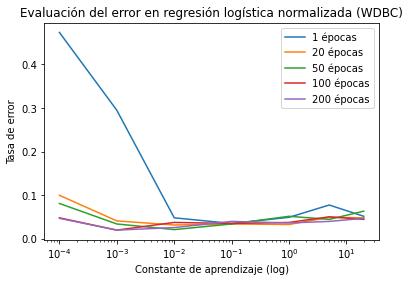

In [75]:
plot_log(datosTablaN,pasos,'Evaluación del error en regresión logística normalizada (WDBC)')

Claramente la conclusión que se saca más a la vista es que una época no es suficiente para garantizar la convergencia. A partir de ahí, aunque con 20 épocas se ve que aún se pueden mejorar los resultados ya parecen mostrar una mejoría notable. 

La segunda conclusión que sacamos es que a partir de 5 la constante de aprendizaje es mala, ya que muestra una cierta subida en los errores a partir de ese dato. También podemos ver que incluso las constantes más bajas muestran muy buenos resultados gracias a la normalización excepto 0.0001, que ya parece excesivamente baja. También podemos observar que el menor error que logramos obtener se logra con 200 épocas y una constante de aprendizaje de 0.001.

Es de esperar que, tras épocas suficientes, fuera 0.0001 quien tuviera el mejor resultado

Respecto a lo demás, se puede concluir que en este modelo 100 épocas son suficientes. Aunque 50 o 20 tampoco está mal, con 100 épocas nos garantizamos una convergencia que parece que no va a presentar mayor mejoría en un mayor número de épocas.

En esta ocasión tenemos una pregunta extra que plantearnos: ¿las constantes de aprendizaje cobran mayor importancia si no se normaliza?

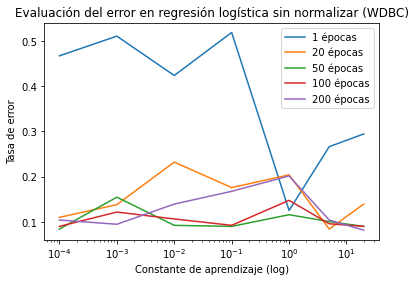

In [76]:
plot_log(datosTabla,pasos,'Evaluación del error en regresión logística sin normalizar (WDBC)')

Tenemos las mismas conclusiones de antes respecto a la época única. Sin embargo, ahora parece que con 200 épocas tenemos un cierto 'caos' que no parece arreglarse si se aumentan las épocas. Sin embargo, parece que el algoritmo converge para constantes 0.0001 y 5, números que parecen bastante aleatorios a priori. Por ello, en esta base de datos es importantísimo normalizar, ya que si no ni siquiera podemos garantizar convergencia.

### 2.2. Indians

Procedemos a tratar con la segunda base de datos. En primer lugar, veamos cómo afecta la normalización a este dataset.

In [77]:
datosTablaN,datosTabla,diff = data_log(constantes,pasos,dataIndians,propTest=0.5)
print_log(datosTablaN,datosTabla,diff,pasos)

C:\Users\David\Desktop\Universidad\FAA\Practicas\faa\p2\Clasificador.py:233: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Sin normalizar:
Cte \ Pasos    1       20      50     100     200  
----------- ------- ------- ------- ------- -------
     0.0001 0.44102  0.4013 0.37461 0.38216 0.36549
      0.001 0.42604 0.41549 0.43516 0.42357 0.43099
       0.01 0.44844 0.40951 0.42917 0.43984 0.37904
        0.1 0.39271 0.43997 0.39297 0.40065 0.40221
        1.0 0.45951  0.4112 0.41523 0.44753 0.46849
        5.0 0.40391 0.42773 0.39792 0.44323 0.46029
       20.0 0.42969 0.42383 0.40312 0.43711 0.37734


Normalizando:
Cte \ Pasos    1       20      50     100     200  
----------- ------- ------- ------- ------- -------
     0.0001 0.48151 0.39076 0.31263 0.25938 0.24258
      0.001 0.45039 0.23789 0.24154 0.22682 0.23529
       0.01 0.26589 0.23594 0.23685 0.23633 0.23229
        0.1 0.23984 0.24622 0.24531 0.24062 0.24596
        1.0 0.30964 0.29805 0.31406 0.29414 0.31042
        5.0 0.31289 0.31003 0.31628 0.28854 0.31185
       20.0 0.30872 0.30924 0.30221 0.31992 0.29818


Diferencias:
Cte \ Pasos    1 

De nuevo con una época no termina de haber convergencia, pero igualmente parece que a partir de cierta constante de aprendizaje se valora muchísimo que se haya normalizado. Si nos vamos a un número de épocas razonable vemos que de nueva importa muchísimo normalizar. En concreto, en la mayoría de casos la diferencia de errores oscila entre el 10% y el 20%. Parece que de nuevo tenemos la misma problemática: sin normalización no existe convergencia en un número de épocas razonable, y puede que nunca haya convergencia.

Una vez analizado que no normalizar en este dataset da resultados catastróficos, pasamos a analizar los datos normalizados.

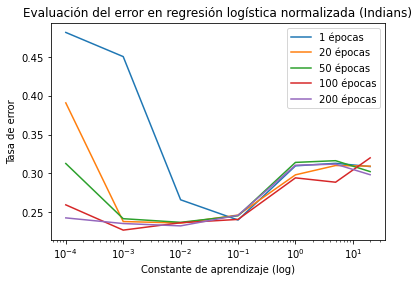

In [78]:
plot_log(datosTablaN,pasos,'Evaluación del error en regresión logística normalizada (Indians)')

Como vemos, los resultados convergen más rápido que en el primer dataset: a partir de 20 épocas alcanzamos unos número excelentes y a partir de 100 épocas parece que hemos tocado techo. Además, en este dataset se castiga muchísimo más a las constantes muy altas: a partir de 1 los errores de la constante de aprendizaje se disparan. También parece que la constante de aprendizaje 0.0001 es demasiado pequeña, y se observa que aún con 200 épocas no se ha alcanzado del todo la convergencia.

Como conclusión, en este dataset los errores se minimizan con una constante de aprendizaje que se encuentre entre 0.001 y 0.01, donde son necesarias unas 100 épocas.

## 3. Scikit-learn

Ahora procedemos a trabajar con las funciones propuestas de scikit-learn para vecinos próximos y para regresión logística. La forma de proceder será al siguiente: se variarán los parámetros correspondientes en las funciones de scikit y en las nuestras y se compararán resultados.

Como ya se ha visto, la normalización es muy necesaria tanto en vecinos próximos como en regresión logísitica, por lo que durante todo este apartado se trabaja únicamente con datos normalizados. Para normalizar los datos en scikit-learn, utilizaremos la función *StandardScaler*.

### 3.1. Vecinos próximos

En este apartado se va a variar el número de vecinos igual que antes, es decir, los valores tomados son 1,5,11,21. Además, se probará con las tres distancias utilizadas anteriormente: euclidea, Manhattan y Mahalanobis. Separaremos los resultados según los dos datasets.

In [107]:
# Obtención de resultados para unos ciertos parámetros
def compare_scipy_knn(distancia,vecinos,data,numEx=5,propTest=0.2):
    particionado = ValidacionSimple(propTest,numEx)
    
    X = data.datos[:,:-1]
    y = data.datos[:,-1].astype('int')

    datosScipy = []
    datosPropios = []
    
    if distancia == 'euclidea':
        dist = 'euclidean'
    else:
        dist = distancia

    for vecino in vecinos:
        # Cálculo de datos Scipy
        results = []
        for _ in range(numEx):
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=propTest)
            
            # Normalización
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            if distancia == 'mahalanobis':
                param = {'V': np.cov(np.transpose(X_train))}
            else:
                param = None
            
            clf = KNeighborsClassifier(n_neighbors=vecino, metric=dist, metric_params=param)
            clf.fit(X_train, y_train)
            results.append(1 - clf.score(X_test,y_test))
        datosScipy.append(np.mean(results))
        
        # Cálculo de datos propios
        clf = ClasificadorVecinosProximos(vecino,distancia=distancia)
        datosPropios.append(np.mean(clf.validacion(particionado,data)))
            
        
    return datosScipy, datosPropios

def plot_diff_knn(vecinos, datosScipy, datosPropios, title=None):
    plt.plot(vecinos,datosScipy, label='Scikit')
    plt.plot(vecinos,datosPropios, label='Propio')
    
    plt.xticks(vecinos)
    plt.legend()
    plt.xlabel('Vecinos')
    plt.ylabel('Tasa de error')
    plt.title(title)
    
    plt.show()
    
vecinos = [1,5,11,21]

#### 3.1.1. WDBC

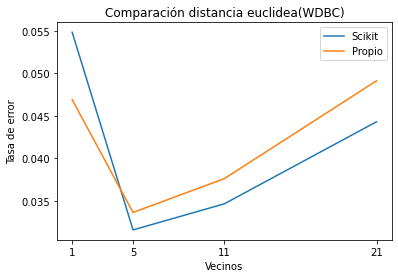

In [111]:
dist = 'euclidea'
scipy, propios = compare_scipy_knn(dist,vecinos,dataWDBC,numEx=20)
plot_diff_knn(vecinos,scipy,propios,title = 'Comparación distancia '+dist+'(WDBC)')

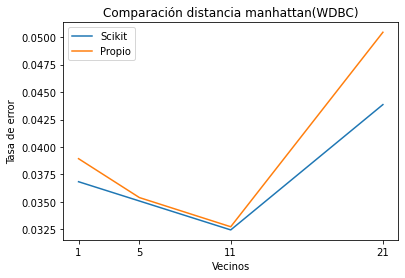

In [110]:
dist = 'manhattan'
scipy, propios = compare_scipy_knn(dist,vecinos,dataWDBC,numEx=10)
plot_diff_knn(vecinos,scipy,propios,title = 'Comparación distancia '+dist+'(WDBC)')

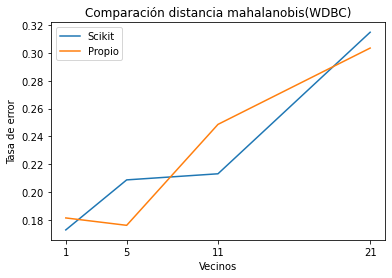

In [108]:
dist = 'mahalanobis'
scipy, propios = compare_scipy_knn(dist,vecinos,dataWDBC,numEx=10)
plot_diff_knn(vecinos,scipy,propios,title = 'Comparación distancia '+dist+'(WDBC)')

Como se puede observar, la diferencia entre la tasa de error de scipy y la nuestra nunca rebasa el 2% (de hecho es muy extraño que rebase el 1%). Con estos resultados, podemos concluir que scipy y nosotros estamos implementando el mismo algoritmo mediante el mismo método (aunque es posible que ellos lo hagan de manera más eficiente).

#### 3.1.2. Indians

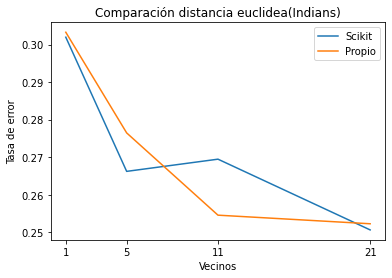

In [115]:
dist = 'euclidea'
scipy, propios = compare_scipy_knn(dist,vecinos,dataIndians,numEx=20)
plot_diff_knn(vecinos,scipy,propios,title = 'Comparación distancia '+dist+'(Indians)')

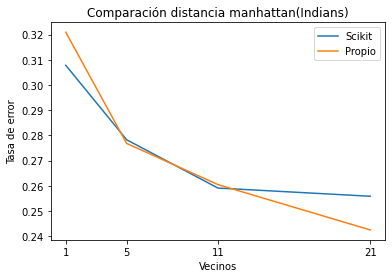

In [113]:
dist = 'manhattan'
scipy, propios = compare_scipy_knn(dist,vecinos,dataIndians,numEx=20)
plot_diff_knn(vecinos,scipy,propios,title = 'Comparación distancia '+dist+'(Indians)')

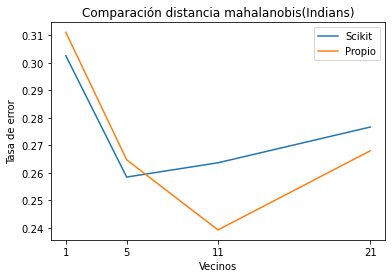

In [116]:
dist = 'mahalanobis'
scipy, propios = compare_scipy_knn(dist,vecinos,dataIndians,numEx=10)
plot_diff_knn(vecinos,scipy,propios,title = 'Comparación distancia '+dist+'(Indians)')

De nuevo, los resultados son prácticamente iguales y las diferencias nunca superan el 2%. Este dataset muestra lo mismo que mostraba el primero: el algoritmo implementado es el mismo.

## 3.2. Regresión logística

Vamos a actuar de la misma forma que en el apartado anterior: variaremos las épocas y la constante de aprendizaje y veremos si se comportan igual nuestro algoritmo y el de scikit-learn. Con más razón que antes solo tendremos en cuenta normalización en este apartado.

Respecto a los parámetros a tomar, esta vez tomaremos menos que en el apartado 2, ya que conocemos a priori qué resultados van a ser mejores y de interés. Por ello, no nos ha parecido necesario incluir el número de épocas 1 y 200, ya que en la primera el algoritmo no alcanzaba convergencia y en la segunda eran demasiadas épocas, ya que con 100 épocas ya se alcanzaban prácticamente los mismos números. Por ello, solo comprobaremos los resultados con 20,50 y 100 épocas.

Respecto a las constantes de aprendizaje, las mayores que 1 no tienen ningún interés, ya que son demasiado grandes. Por lo demás vamos a probar el resto, ya que aunque algunas dieran malos resultados pueden ser ilustrativas.

In [129]:
def compare_scipy_reg(ctes,epoca,data,numEx=5,propTest=0.5):
    particionado = ValidacionSimple(propTest,numEx)
    
    X = data.datos[:,:-1]
    y = data.datos[:,-1].astype('int')

    datosScipy = []
    datosPropios = []

    for cte in ctes:
        # Cálculo de datos Scipy
        results = []
        for _ in range(numEx):
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=propTest)
            
            # Normalización
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            clf = SGDClassifier(learning_rate='constant',eta0=cte,tol=None,max_iter=epoca)
            clf.fit(X_train, y_train)
            results.append(1 - clf.score(X_test,y_test))
        datosScipy.append(np.mean(results))
        
        # Cálculo de datos propios
        clf = ClasificadorRegresionLogistica(eta=cte,epochs=epoca)
        datosPropios.append(np.mean(clf.validacion(particionado,data)))
        
    return datosScipy, datosPropios

def plot_diff_reg(ctes, datosScipy, datosPropios, title=None):
    plt.plot(ctes,datosScipy,label='Scipy')
    plt.plot(ctes,datosPropios,label='Propios')
    
    plt.xscale('log')
    
    plt.legend()
    plt.xlabel('Constante de aprendizaje')
    plt.ylabel('Tasa de error')
    plt.title(title)
    
    plt.show()
    
ctes = [0.0001,0.001,0.01,0.1,1]

### 3.2.1. WDBC

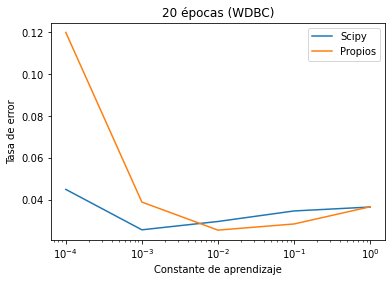

In [137]:
# 20 epocas
ep = 20
scipy, propios = compare_scipy_reg(ctes,ep,dataWDBC,numEx=30)
plot_diff_reg(ctes, scipy, propios, title=str(ep)+' épocas (WDBC)')

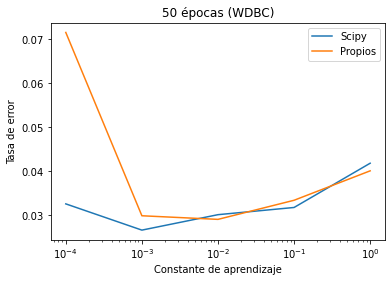

In [138]:
# 50 epocas
ep = 50
scipy, propios = compare_scipy_reg(ctes,ep,dataWDBC,numEx=30)
plot_diff_reg(ctes, scipy, propios, title=str(ep)+' épocas (WDBC)')

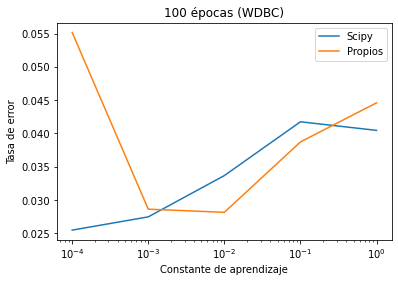

In [139]:
# 100 epocas
ep = 100
scipy, propios = compare_scipy_reg(ctes,ep,dataWDBC,numEx=30)
plot_diff_reg(ctes, scipy, propios, title=str(ep)+' épocas (WDBC)')

De nuevo, cuando la constante de aprendizaje es suficientemente grande tenemos una diferencia muy pequeña entre los dos algoritmos, menor de 1% normalmente. Sin embargo, tenemos un comportamiento muy interesante cuando las constantes son demasiado pequeñas: el algoritmo de scipy es bastante mejor que el nuestro. La razón principal se puede imaginar: scipy inicializa el vector inicial con más precisión que nosotros. En la segunda base de datos podremos comprobar si el comportamiento se repite o se mantiene.

### 3.2.2. Indians

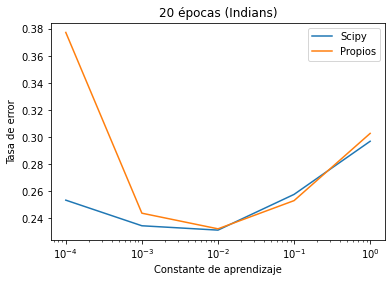

In [140]:
# 20 epocas
ep = 20
scipy, propios = compare_scipy_reg(ctes,ep,dataIndians,numEx=30)
plot_diff_reg(ctes, scipy, propios, title=str(ep)+' épocas (Indians)')

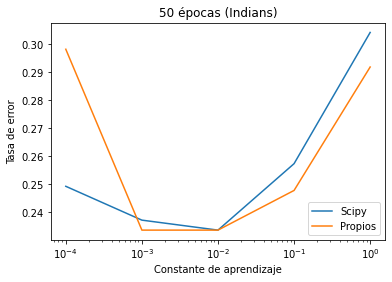

In [141]:
# 50 epocas
ep = 50
scipy, propios = compare_scipy_reg(ctes,ep,dataIndians,numEx=30)
plot_diff_reg(ctes, scipy, propios, title=str(ep)+' épocas (Indians)')

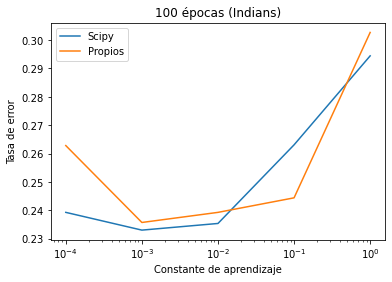

In [142]:
# 100 epocas
ep = 100
scipy, propios = compare_scipy_reg(ctes,ep,dataIndians,numEx=30)
plot_diff_reg(ctes, scipy, propios, title=str(ep)+' épocas (Indians)')

La misma tendencia que antes: a constantes similares los algoritmos se comportan igual, pero con constantes pequeñas los algoritmos de Scipy son bastante mejores. Además, parece que esa 'ventaja' que tiene Scipy se va reduciendo según aumenta el número de épocas. Esto hace que nuestra teoría de que Scipy está mejor preparado para una *cold start* tenga mucho sentido.